# Data Selection - RoBERTA, MRPC
This script trains the RoBERTA model on the entire training dataset and calculates all three types of Influence Values, which are stored in a JSON file.

It later creates new dataloaders from selected data subsets and trains on those dataloaders multiple times to get confidence interval of the accuracy score.

**NOTE:** You can change the `task` variable to run this script for other tasks. It is set to mrpc by default.

Modified from `notebooks\Mislabeled_Data_Detection-RoBERTa-MRPC.ipynb`.

## SET-UP

In [ ]:
import pickle 
import sys
sys.path.append('../src')
from dataloader import create_dataloaders
from lora_model import LORAEngine
from influence import IFEngine

import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

In [ ]:
NUM_RUNS = 5
model_name_or_path="roberta-large"
task="mrpc" #qnli,qqp, sst2
noise_ratio=0
batch_size=32
target_modules=["value"]
device="cuda"
num_epochs=10
lr=3e-4
low_rank=4

results_dict = {'identity': [],
                'proposed': [],
                'LiSSA': [],
                'full': [],
                'random': []}

display_names = {
    "identity": "Hessian-free",
    "full": "Full",
    "proposed": "DataInf",
    "random": "Random",
    "LiSSA": "LiSSA"
}

## Full training

In [ ]:
dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size)

train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn=dataloader_outputs

lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=low_rank, 
                            task=task)

lora_engine.build_LORA_model()
results = lora_engine.train_LORA_model()

## Calculate influence values

In [1]:
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn)

influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)
influence_engine.compute_hvps(compute_accurate=False)
influence_engine.compute_IF()

with open('IF_dict.pkl', 'wb') as f:
    pickle.dump(influence_engine.IF_dict, f)

influence_engine.IF_dict["random"] = np.random.uniform(low=0.0, high=1.0, size=len(influence_engine.IF_dict["proposed"]))

data_loaders = {}
for method, scores in influence_engine.IF_dict.items():
    filtered_ids = np.where(scores > np.percentile(scores, 20))[0]
    filtered_train_dataset = tokenized_datasets["train"].select(filtered_ids)
    filtered_train_dataloader = DataLoader(filtered_train_dataset,
                                            shuffle=True, 
                                            collate_fn=collate_fn,
                                            batch_size=batch_size)
    data_loaders[method] = filtered_train_dataloader 

data_loaders["full"] = train_dataloader

c:\Users\jafar\OneDrive\Desktop\phd\DataInf\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 1: {'accuracy': 0.7034313725490197, 'f1': 0.815267175572519}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 2: {'accuracy': 0.7745098039215687, 'f1': 0.8408304498269896}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 3: {'accuracy': 0.7671568627450981, 'f1': 0.810379241516966}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 4: {'accuracy': 0.8480392156862745, 'f1': 0.8884892086330936}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 5: {'accuracy': 0.8651960784313726, 'f1': 0.9056603773584906}


100%|██████████| 13/13 [00:03<00:00,  3.73it/s]


Epoch 6: {'accuracy': 0.8651960784313726, 'f1': 0.896421845574388}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 7: {'accuracy': 0.875, 'f1': 0.9094138543516874}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 8: {'accuracy': 0.8676470588235294, 'f1': 0.9021739130434783}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 9: {'accuracy': 0.8725490196078431, 'f1': 0.9064748201438849}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 10: {'accuracy': 0.8676470588235294, 'f1': 0.9039145907473309}


100%|██████████| 408/408 [00:15<00:00, 26.52it/s]


## DataInf, Hessian-free, LiSSA, Random, and Full training

In [4]:
for method, data_loader in data_loaders.items():
    for _ in range(NUM_RUNS):
        filtered_lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                                target_modules=target_modules,
                                train_dataloader=data_loader,
                                eval_dataloader=eval_dataloader,
                                device=device,
                                num_epochs=num_epochs,
                                lr=lr,
                                low_rank=low_rank, 
                                task=task)
        filtered_lora_engine.build_LORA_model()
        results = filtered_lora_engine.train_LORA_model()    
        results_dict[method].append(results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 2: {'accuracy': 0.7083333333333334, 'f1': 0.8221225710014948}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 3: {'accuracy': 0.7450980392156863, 'f1': 0.8409785932721713}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 4: {'accuracy': 0.7524509803921569, 'f1': 0.8448540706605223}


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 5: {'accuracy': 0.7916666666666666, 'f1': 0.8661417322834646}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 6: {'accuracy': 0.7916666666666666, 'f1': 0.8661417322834646}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 7: {'accuracy': 0.8063725490196079, 'f1': 0.8731942215088283}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 8: {'accuracy': 0.8161764705882353, 'f1': 0.8784440842787682}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 9: {'accuracy': 0.8137254901960784, 'f1': 0.8778135048231511}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 10: {'accuracy': 0.8088235294117647, 'f1': 0.8753993610223643}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 2: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 3: {'accuracy': 0.8014705882352942, 'f1': 0.8656716417910447}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 4: {'accuracy': 0.7990196078431373, 'f1': 0.867741935483871}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 5: {'accuracy': 0.7892156862745098, 'f1': 0.8639240506329114}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 6: {'accuracy': 0.7990196078431373, 'f1': 0.8694267515923567}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 7: {'accuracy': 0.8406862745098039, 'f1': 0.8936170212765957}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 8: {'accuracy': 0.8284313725490197, 'f1': 0.8859934853420195}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.8235294117647058, 'f1': 0.883495145631068}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 10: {'accuracy': 0.8186274509803921, 'f1': 0.8806451612903226}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 2: {'accuracy': 0.7058823529411765, 'f1': 0.8203592814371258}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 3: {'accuracy': 0.8137254901960784, 'f1': 0.8689655172413793}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 4: {'accuracy': 0.8137254901960784, 'f1': 0.8774193548387097}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 5: {'accuracy': 0.8259803921568627, 'f1': 0.8830313014827018}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 6: {'accuracy': 0.8112745098039216, 'f1': 0.8760064412238325}


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Epoch 7: {'accuracy': 0.8406862745098039, 'f1': 0.8932676518883416}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 8: {'accuracy': 0.8088235294117647, 'f1': 0.8753993610223643}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.8259803921568627, 'f1': 0.8849270664505673}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 10: {'accuracy': 0.821078431372549, 'f1': 0.8820678513731826}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Epoch 2: {'accuracy': 0.6887254901960784, 'f1': 0.8145985401459854}


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Epoch 3: {'accuracy': 0.696078431372549, 'f1': 0.8176470588235294}


100%|██████████| 13/13 [00:03<00:00,  3.73it/s]


Epoch 4: {'accuracy': 0.7671568627450981, 'f1': 0.8531684698608965}


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Epoch 5: {'accuracy': 0.8014705882352942, 'f1': 0.8695652173913043}


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Epoch 6: {'accuracy': 0.8480392156862745, 'f1': 0.8956228956228957}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 7: {'accuracy': 0.8088235294117647, 'f1': 0.875}


100%|██████████| 13/13 [00:03<00:00,  3.65it/s]


Epoch 8: {'accuracy': 0.8235294117647058, 'f1': 0.8819672131147541}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.821078431372549, 'f1': 0.8820678513731826}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 10: {'accuracy': 0.8284313725490197, 'f1': 0.8863636363636364}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 1: {'accuracy': 0.6887254901960784, 'f1': 0.8145985401459854}


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Epoch 2: {'accuracy': 0.7352941176470589, 'f1': 0.8358662613981763}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 3: {'accuracy': 0.7696078431372549, 'f1': 0.853125}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 4: {'accuracy': 0.8112745098039216, 'f1': 0.875605815831987}


100%|██████████| 13/13 [00:03<00:00,  3.73it/s]


Epoch 5: {'accuracy': 0.8137254901960784, 'f1': 0.8774193548387097}


100%|██████████| 13/13 [00:03<00:00,  3.73it/s]


Epoch 6: {'accuracy': 0.8333333333333334, 'f1': 0.8885245901639345}


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Epoch 7: {'accuracy': 0.8186274509803921, 'f1': 0.8802588996763754}


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Epoch 8: {'accuracy': 0.7916666666666666, 'f1': 0.8665620094191523}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 9: {'accuracy': 0.8014705882352942, 'f1': 0.8716323296354992}


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Epoch 10: {'accuracy': 0.8088235294117647, 'f1': 0.875}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Epoch 1: {'accuracy': 0.696078431372549, 'f1': 0.8171091445427728}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 2: {'accuracy': 0.7034313725490197, 'f1': 0.8191330343796711}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 3: {'accuracy': 0.8284313725490197, 'f1': 0.8841059602649006}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.8186274509803921, 'f1': 0.8802588996763754}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 5: {'accuracy': 0.8406862745098039, 'f1': 0.8939641109298532}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 6: {'accuracy': 0.8112745098039216, 'f1': 0.8768}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 7: {'accuracy': 0.8308823529411765, 'f1': 0.8881685575364667}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 8: {'accuracy': 0.8333333333333334, 'f1': 0.889967637540453}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 9: {'accuracy': 0.821078431372549, 'f1': 0.8828250401284109}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 10: {'accuracy': 0.8259803921568627, 'f1': 0.8856682769726248}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 2: {'accuracy': 0.7034313725490197, 'f1': 0.8202080237741456}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 3: {'accuracy': 0.7745098039215687, 'f1': 0.8557993730407524}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 4: {'accuracy': 0.8137254901960784, 'f1': 0.8754098360655738}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 5: {'accuracy': 0.7843137254901961, 'f1': 0.861198738170347}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 6: {'accuracy': 0.8088235294117647, 'f1': 0.8741935483870967}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 7: {'accuracy': 0.8284313725490197, 'f1': 0.8856209150326797}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 8: {'accuracy': 0.8284313725490197, 'f1': 0.8856209150326797}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 9: {'accuracy': 0.8063725490196079, 'f1': 0.8731942215088283}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 10: {'accuracy': 0.8137254901960784, 'f1': 0.8774193548387097}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


Epoch 1: {'accuracy': 0.6887254901960784, 'f1': 0.8145985401459854}


100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


Epoch 2: {'accuracy': 0.7009803921568627, 'f1': 0.8173652694610778}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 3: {'accuracy': 0.75, 'f1': 0.8440366972477065}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 4: {'accuracy': 0.803921568627451, 'f1': 0.8679867986798679}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 5: {'accuracy': 0.7941176470588235, 'f1': 0.8675078864353313}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 6: {'accuracy': 0.8063725490196079, 'f1': 0.8740031897926634}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 7: {'accuracy': 0.7941176470588235, 'f1': 0.8675078864353313}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 8: {'accuracy': 0.8137254901960784, 'f1': 0.8782051282051282}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 9: {'accuracy': 0.8284313725490197, 'f1': 0.8863636363636364}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 10: {'accuracy': 0.8259803921568627, 'f1': 0.8849270664505673}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 2: {'accuracy': 0.6936274509803921, 'f1': 0.8169838945827232}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 3: {'accuracy': 0.6936274509803921, 'f1': 0.8169838945827232}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 4: {'accuracy': 0.8259803921568627, 'f1': 0.8834154351395731}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 5: {'accuracy': 0.7598039215686274, 'f1': 0.850609756097561}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 6: {'accuracy': 0.8431372549019608, 'f1': 0.893687707641196}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 7: {'accuracy': 0.8235294117647058, 'f1': 0.8819672131147541}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 8: {'accuracy': 0.8063725490196079, 'f1': 0.8751974723538705}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 9: {'accuracy': 0.8308823529411765, 'f1': 0.8881685575364667}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 10: {'accuracy': 0.8137254901960784, 'f1': 0.8782051282051282}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Epoch 2: {'accuracy': 0.7058823529411765, 'f1': 0.8219584569732937}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 3: {'accuracy': 0.7132352941176471, 'f1': 0.8240601503759398}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 4: {'accuracy': 0.7818627450980392, 'f1': 0.8598425196850393}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 5: {'accuracy': 0.7671568627450981, 'f1': 0.8536209553158706}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 6: {'accuracy': 0.7696078431372549, 'f1': 0.853125}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 7: {'accuracy': 0.8112745098039216, 'f1': 0.8760064412238325}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 8: {'accuracy': 0.8308823529411765, 'f1': 0.8874388254486134}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 9: {'accuracy': 0.8137254901960784, 'f1': 0.8778135048231511}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 10: {'accuracy': 0.8161764705882353, 'f1': 0.8792270531400966}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 2: {'accuracy': 0.7009803921568627, 'f1': 0.8205882352941176}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 3: {'accuracy': 0.7524509803921569, 'f1': 0.8448540706605223}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 4: {'accuracy': 0.7475490196078431, 'f1': 0.8427480916030534}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 5: {'accuracy': 0.8259803921568627, 'f1': 0.8830313014827018}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 6: {'accuracy': 0.8259803921568627, 'f1': 0.8845528455284553}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 7: {'accuracy': 0.8284313725490197, 'f1': 0.8848684210526315}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 8: {'accuracy': 0.8259803921568627, 'f1': 0.8841761827079935}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.8284313725490197, 'f1': 0.8856209150326797}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 10: {'accuracy': 0.8308823529411765, 'f1': 0.8870703764320785}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 2: {'accuracy': 0.7034313725490197, 'f1': 0.8212703101920237}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 3: {'accuracy': 0.7352941176470589, 'f1': 0.8358662613981763}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 4: {'accuracy': 0.7377450980392157, 'f1': 0.8390977443609022}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 5: {'accuracy': 0.8259803921568627, 'f1': 0.8841761827079935}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 6: {'accuracy': 0.8333333333333334, 'f1': 0.8892508143322475}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 7: {'accuracy': 0.8357843137254902, 'f1': 0.8910569105691057}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 8: {'accuracy': 0.7941176470588235, 'f1': 0.8679245283018868}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 9: {'accuracy': 0.8529411764705882, 'f1': 0.9003322259136213}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 10: {'accuracy': 0.8406862745098039, 'f1': 0.8939641109298532}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 2: {'accuracy': 0.7107843137254902, 'f1': 0.8217522658610272}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 3: {'accuracy': 0.6887254901960784, 'f1': 0.8145985401459854}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 4: {'accuracy': 0.8137254901960784, 'f1': 0.8766233766233766}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 5: {'accuracy': 0.7818627450980392, 'f1': 0.8607198748043818}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 6: {'accuracy': 0.8112745098039216, 'f1': 0.8764044943820225}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 7: {'accuracy': 0.8382352941176471, 'f1': 0.8921568627450981}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 8: {'accuracy': 0.8112745098039216, 'f1': 0.8764044943820225}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 9: {'accuracy': 0.8235294117647058, 'f1': 0.883495145631068}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 10: {'accuracy': 0.8112745098039216, 'f1': 0.8764044943820225}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 2: {'accuracy': 0.7058823529411765, 'f1': 0.8165137614678899}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 3: {'accuracy': 0.7647058823529411, 'f1': 0.8504672897196262}


100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Epoch 4: {'accuracy': 0.7720588235294118, 'f1': 0.8567026194144838}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 5: {'accuracy': 0.7941176470588235, 'f1': 0.8683385579937304}


100%|██████████| 13/13 [00:03<00:00,  3.73it/s]


Epoch 6: {'accuracy': 0.8308823529411765, 'f1': 0.8866995073891626}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 7: {'accuracy': 0.8284313725490197, 'f1': 0.8856209150326797}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 8: {'accuracy': 0.8235294117647058, 'f1': 0.8838709677419355}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 9: {'accuracy': 0.821078431372549, 'f1': 0.8820678513731826}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 10: {'accuracy': 0.8137254901960784, 'f1': 0.8785942492012779}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 2: {'accuracy': 0.7034313725490197, 'f1': 0.8212703101920237}


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Epoch 3: {'accuracy': 0.7892156862745098, 'f1': 0.8634920634920635}


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Epoch 4: {'accuracy': 0.7720588235294118, 'f1': 0.8553654743390358}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 5: {'accuracy': 0.8088235294117647, 'f1': 0.8745980707395499}


100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Epoch 6: {'accuracy': 0.7990196078431373, 'f1': 0.8698412698412699}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 7: {'accuracy': 0.8308823529411765, 'f1': 0.8870703764320785}


100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Epoch 8: {'accuracy': 0.8161764705882353, 'f1': 0.8796147672552167}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 9: {'accuracy': 0.8235294117647058, 'f1': 0.8838709677419355}


100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Epoch 10: {'accuracy': 0.8186274509803921, 'f1': 0.8802588996763754}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 2: {'accuracy': 0.7524509803921569, 'f1': 0.830820770519263}


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Epoch 3: {'accuracy': 0.7892156862745098, 'f1': 0.8621794871794872}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 4: {'accuracy': 0.8235294117647058, 'f1': 0.8783783783783784}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 5: {'accuracy': 0.7916666666666666, 'f1': 0.8652931854199684}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 6: {'accuracy': 0.8529411764705882, 'f1': 0.8954703832752613}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 7: {'accuracy': 0.8382352941176471, 'f1': 0.8910891089108911}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 8: {'accuracy': 0.8676470588235294, 'f1': 0.9045936395759717}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 9: {'accuracy': 0.8578431372549019, 'f1': 0.8993055555555556}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 10: {'accuracy': 0.8578431372549019, 'f1': 0.897887323943662}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 2: {'accuracy': 0.7818627450980392, 'f1': 0.8533772652388797}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 3: {'accuracy': 0.7083333333333334, 'f1': 0.8226527570789866}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 4: {'accuracy': 0.8137254901960784, 'f1': 0.8628158844765343}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 5: {'accuracy': 0.821078431372549, 'f1': 0.8781302170283807}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 6: {'accuracy': 0.8161764705882353, 'f1': 0.8772504091653028}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 7: {'accuracy': 0.8480392156862745, 'f1': 0.8872727272727273}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 8: {'accuracy': 0.8480392156862745, 'f1': 0.8952702702702703}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 9: {'accuracy': 0.8553921568627451, 'f1': 0.8981001727115717}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 10: {'accuracy': 0.8602941176470589, 'f1': 0.9032258064516129}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 2: {'accuracy': 0.7205882352941176, 'f1': 0.8240740740740741}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 3: {'accuracy': 0.7867647058823529, 'f1': 0.8585365853658536}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 4: {'accuracy': 0.8333333333333334, 'f1': 0.8859060402684564}


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Epoch 5: {'accuracy': 0.8406862745098039, 'f1': 0.8911222780569514}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 6: {'accuracy': 0.8627450980392157, 'f1': 0.9027777777777778}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 7: {'accuracy': 0.8700980392156863, 'f1': 0.9061946902654867}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 8: {'accuracy': 0.875, 'f1': 0.91005291005291}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 9: {'accuracy': 0.8774509803921569, 'f1': 0.9134948096885813}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 10: {'accuracy': 0.8774509803921569, 'f1': 0.9122807017543859}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 1: {'accuracy': 0.6666666666666666, 'f1': 0.7841269841269841}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 2: {'accuracy': 0.75, 'f1': 0.8391167192429022}


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 3: {'accuracy': 0.8137254901960784, 'f1': 0.8737541528239202}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 4: {'accuracy': 0.8308823529411765, 'f1': 0.883248730964467}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 5: {'accuracy': 0.8578431372549019, 'f1': 0.8996539792387543}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 6: {'accuracy': 0.8651960784313726, 'f1': 0.8979591836734694}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 7: {'accuracy': 0.8627450980392157, 'f1': 0.900355871886121}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 8: {'accuracy': 0.8676470588235294, 'f1': 0.9042553191489362}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 9: {'accuracy': 0.8799019607843137, 'f1': 0.9126559714795008}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 10: {'accuracy': 0.8676470588235294, 'f1': 0.9052631578947369}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Epoch 1: {'accuracy': 0.6936274509803921, 'f1': 0.8164464023494861}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 2: {'accuracy': 0.7034313725490197, 'f1': 0.8191330343796711}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 3: {'accuracy': 0.7647058823529411, 'f1': 0.8222222222222222}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 4: {'accuracy': 0.8259803921568627, 'f1': 0.8798646362098139}


100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Epoch 5: {'accuracy': 0.8676470588235294, 'f1': 0.9010989010989011}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 6: {'accuracy': 0.8602941176470589, 'f1': 0.9025641025641026}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 7: {'accuracy': 0.8799019607843137, 'f1': 0.9147826086956522}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 8: {'accuracy': 0.8725490196078431, 'f1': 0.9084507042253521}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 9: {'accuracy': 0.8651960784313726, 'f1': 0.9029982363315696}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 10: {'accuracy': 0.8725490196078431, 'f1': 0.9094076655052264}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Epoch 1: {'accuracy': 0.7009803921568627, 'f1': 0.8195266272189349}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.7867647058823529, 'f1': 0.8599033816425121}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 3: {'accuracy': 0.8431372549019608, 'f1': 0.8836363636363637}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 4: {'accuracy': 0.8578431372549019, 'f1': 0.9006849315068494}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 5: {'accuracy': 0.8480392156862745, 'f1': 0.8834586466165414}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 6: {'accuracy': 0.8651960784313726, 'f1': 0.8968105065666041}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 7: {'accuracy': 0.8700980392156863, 'f1': 0.9020332717190388}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 8: {'accuracy': 0.875, 'f1': 0.9050279329608939}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.8799019607843137, 'f1': 0.9080675422138836}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 10: {'accuracy': 0.8602941176470589, 'f1': 0.896551724137931}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 1: {'accuracy': 0.696078431372549, 'f1': 0.8165680473372781}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 2: {'accuracy': 0.7794117647058824, 'f1': 0.8571428571428571}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 3: {'accuracy': 0.7941176470588235, 'f1': 0.864516129032258}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 4: {'accuracy': 0.8504901960784313, 'f1': 0.8953687821612349}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 5: {'accuracy': 0.8553921568627451, 'f1': 0.8973913043478261}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 6: {'accuracy': 0.8700980392156863, 'f1': 0.9071803852889667}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 7: {'accuracy': 0.8799019607843137, 'f1': 0.9100917431192661}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 8: {'accuracy': 0.8602941176470589, 'f1': 0.9008695652173913}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 9: {'accuracy': 0.875, 'f1': 0.9074410163339383}


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 10: {'accuracy': 0.8700980392156863, 'f1': 0.9055258467023173}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 2: {'accuracy': 0.7475490196078431, 'f1': 0.8377952755905512}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 3: {'accuracy': 0.8137254901960784, 'f1': 0.8618181818181818}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 4: {'accuracy': 0.8725490196078431, 'f1': 0.9064748201438849}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 5: {'accuracy': 0.8651960784313726, 'f1': 0.8968105065666041}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 6: {'accuracy': 0.8897058823529411, 'f1': 0.918625678119349}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 7: {'accuracy': 0.8970588235294118, 'f1': 0.9247311827956989}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 8: {'accuracy': 0.8995098039215687, 'f1': 0.925589836660617}


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 9: {'accuracy': 0.8872549019607843, 'f1': 0.9187279151943463}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 10: {'accuracy': 0.8848039215686274, 'f1': 0.91651865008881}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


Epoch 1: {'accuracy': 0.7132352941176471, 'f1': 0.8245877061469266}


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


Epoch 2: {'accuracy': 0.7671568627450981, 'f1': 0.848966613672496}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 3: {'accuracy': 0.7818627450980392, 'f1': 0.8571428571428571}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 4: {'accuracy': 0.7843137254901961, 'f1': 0.819672131147541}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 5: {'accuracy': 0.8504901960784313, 'f1': 0.8953687821612349}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 6: {'accuracy': 0.875, 'f1': 0.9087656529516994}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 7: {'accuracy': 0.8799019607843137, 'f1': 0.9123434704830053}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 8: {'accuracy': 0.8774509803921569, 'f1': 0.9100719424460432}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.875, 'f1': 0.9074410163339383}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 10: {'accuracy': 0.8774509803921569, 'f1': 0.9100719424460432}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,299,908 || all params: 356,610,052 || trainable%: 0.6449363911929212


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 1: {'accuracy': 0.6936274509803921, 'f1': 0.8169838945827232}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 2: {'accuracy': 0.7230392156862745, 'f1': 0.8242612752721618}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 3: {'accuracy': 0.8186274509803921, 'f1': 0.8766666666666667}


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 4: {'accuracy': 0.8480392156862745, 'f1': 0.8856088560885609}


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


Epoch 5: {'accuracy': 0.8480392156862745, 'f1': 0.8949152542372881}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 6: {'accuracy': 0.8700980392156863, 'f1': 0.9068541300527241}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 7: {'accuracy': 0.8578431372549019, 'f1': 0.9003436426116839}


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 8: {'accuracy': 0.8676470588235294, 'f1': 0.90625}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 9: {'accuracy': 0.8823529411764706, 'f1': 0.9142857142857143}


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]

Epoch 10: {'accuracy': 0.8799019607843137, 'f1': 0.9126559714795008}


## Visualization

In [ ]:
import numpy as np
import scipy.stats as stats

def confidence_interval(data, confidence=0.95):
    # Convert the list to a numpy array for easier mathematical operations
    data = np.array(data)
    
    # Calculate the mean
    mean = np.mean(data)
    
    # Calculate the standard error
    sem = stats.sem(data)
    
    # Get the t-score for the 95% confidence level with degrees of freedom (n-1)
    t_score = stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    
    # Calculate the margin of error
    margin_of_error = t_score * sem
    
    # Calculate the confidence interval
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    
    return lower_bound, upper_bound

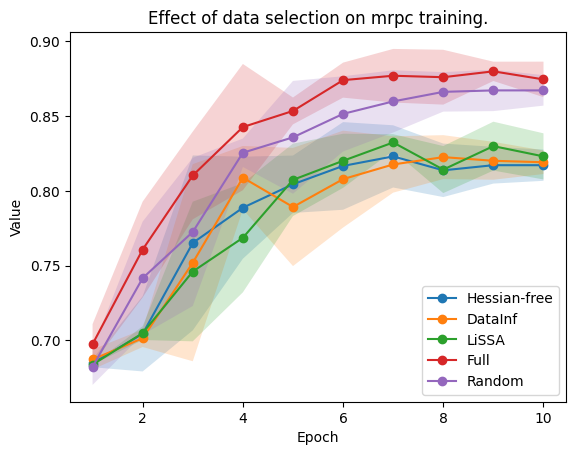

In [25]:
for method, results in results_dict.items():
    results = np.array(results).T
    mean = np.mean(results, axis=1)
    # print(mean)
    lower_bound = [confidence_interval(i)[0] for i in results]
    upper_bound = [confidence_interval(i)[1] for i in results]
    epochs = range(1, len(mean) + 1)
    
    plt.plot(epochs, mean, label=f'{display_names[method]}', linestyle='-', marker='o')
    
    # Fill between the upper and lower bounds to show the confidence interval
    plt.fill_between(epochs, lower_bound, upper_bound, alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title(f'Effect of data selection on {task} training.')
plt.legend(loc='best')
plt.savefig(f"{task}_plot.png")